In [12]:
from rdflib import Graph 
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=N9c88b7c38b6e4c7395c883593d2c040c (<class 'rdflib.graph.Graph'>)>

In [3]:
# Bacnet Devices

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Device
query_for_devices = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name
WHERE {
  ?device a bacnet:bacnet_Device ;
          bacnet:device_name ?device_name .
}
"""

# Run the query for devices
for row in g.query(query_for_devices):
    device_name = row[0]

    # Create the document
    content = device_name.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [19]:
# Bacnet Points

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Point
query_for_points = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name ?point_name ?present_value ?unit
WHERE {
  ?point a bacnet:bacnet_Point ;
         bacnet:device_name ?device_name ;
         bacnet:object_name ?point_name ;
         bacnet:present_value ?present_value ;
         bacnet:object_units ?unit .
}
"""

# Run the query for points
for row in g.query(query_for_points):
    device_name, point_name, present_value, unit = row
    
    content = point_name + " " + present_value + " " + unit
    documents.append(Document(page_content=content, metadata={"type": "bacnet_point"}))

In [4]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [5]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]
embs = np.vstack(embs)
embs.shape

  2%|▏         | 4/199 [00:01<01:24,  2.30it/s]


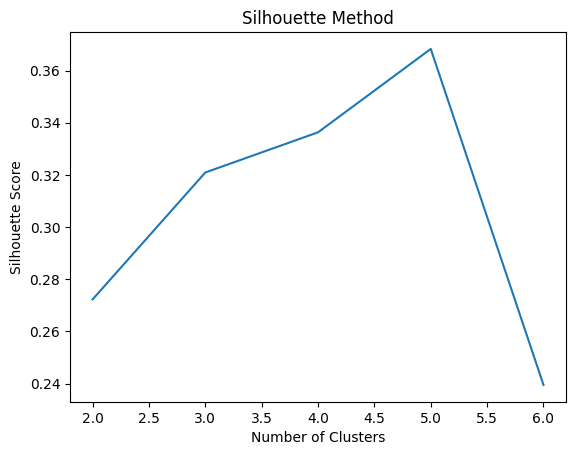

Optimal number of clusters:  5


In [7]:
# Determine the optimal number of clusters

sil = [] # list of silhouette scores
kmin = 2 # minimum number of clusters
kmax = 200 # maximum number of clusters

for k in tqdm(range(kmin, kmax+1)):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=10).fit(embs) # adjust batch_size as needed
    labels = kmeans.labels_
    sil.append(silhouette_score(embs, labels, metric='euclidean')) # adjust sample_size as needed

    # Early stopping
    if k > 2 and sil[k-kmin] < sil[k-kmin-1]:
        break

optimal_clusters = np.argmax(sil) + kmin  # +kmin because the range starts from kmin

actual_kmax = k  # Add this line after the loop
plt.plot(range(kmin, actual_kmax+1), sil)
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

print("Optimal number of clusters: ", optimal_clusters)

In [8]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
cluster_assignments = kmeans.fit_predict(embs)
labels = kmeans.labels_

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


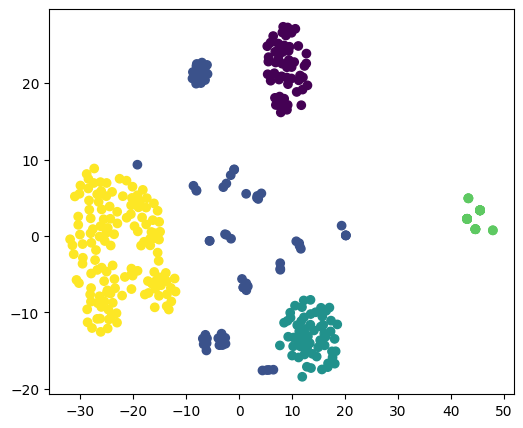

In [10]:
# Plot the clusters
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Convert list to numpy array
embs_array = np.array(embs)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embs_array)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments)
plt.show()

In [11]:
# Create a dictionary of clusters, with the key being the cluster number and the value being the list of documents in that cluster
cluster_dict = {}
for i in range(len(labels)):
    cluster_dict.setdefault(labels[i], []).append(documents[i])

# Print the clusters
for cluster in cluster_dict:
    print("Cluster", cluster)
    for document in cluster_dict[cluster]:
        print(document.metadata["type"], document.page_content)
    print()

Cluster 1
bacnet_device Engineering
bacnet_device Engineering
bacnet_device Engineering
bacnet_device Eaton Drive-1
bacnet_device Eaton Drive-11
bacnet_device BTU METER 1020
bacnet_device BTU METER 1021
bacnet_device BTU METER 1022
bacnet_device Eaton Drive-3
bacnet_device AHU-3 AFMS
bacnet_device Eaton Drive-31
bacnet_device ATV212
bacnet_device Eaton Drive-4
bacnet_device Eaton Drive-5
bacnet_device Eaton Drive-7
bacnet_device CHILLED/COND WATER
bacnet_device MTIIChillerUC100001
bacnet_device pCOWeb88004
bacnet_device enteliBUS Manager 4104766
bacnet_device MTIIChillerUC200002
bacnet_device Volttron BACnet driver
bacnet_device HOT WATER PLANT
bacnet_device 
bacnet_device A-WING FLRS 3&4 DOAS2
bacnet_device Device_0030de05fef2
bacnet_device B-WING VAVS
bacnet_device AHU1
bacnet_device AHU2
bacnet_device AHU3
bacnet_device AHU5
bacnet_device AHU6
bacnet_device AHU7
bacnet_device C-WING RTU DOAS1&6
bacnet_device A-WING FLOORS 1&2
bacnet_device Eaton Drive-14
bacnet_device Eaton Drive-16